In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imgw_api import get_hydro_metadata,get_meteo_metadata
from imgw_static import get_map_wojewodztwa
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils_maps import plot_zlewnia_stat

### Wczytanie Danych

In [3]:
zlewnie = gpd.read_file('../static_data/zlewnie/zlewnie_2.gpkg')
zlewnie = zlewnie.rename(columns={"objectid" : "Zlewnia ID"})
meteo = pd.read_parquet("../static_data/filtered_meteo_opad_data.parquet.gzip")
hydro = pd.read_parquet("../static_data/filtered_hydro_data.parquet.gzip")
gdf_h = get_hydro_metadata(True)
gdf_m = get_meteo_metadata(True)

<Axes: >

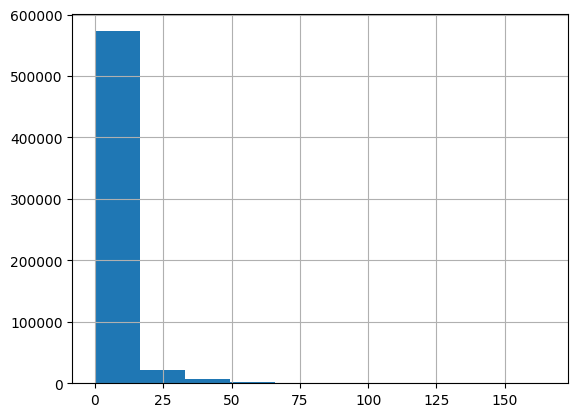

In [6]:
meteo['Snow Cover Height'].hist()

### Analiza Danych Hydrologicznych na poziomie Zlewni - 2

In [3]:
# Dołączenie stacji hydrologicznych do zlewni
gdf_h_zlewnia = gpd.sjoin(gdf_h, zlewnie, how='inner', predicate='within').drop(['naz_zlewni','id_hyd_10','id_hyd_50','guid'],axis=1)

Mapowanie Id Zlewnie do danych pomiarowych

In [4]:
map_hydro = gdf_h_zlewnia.set_index('Station Code')['Zlewnia ID']
hydro['Zlewnia ID'] = hydro['Station Code'].map(map_hydro)

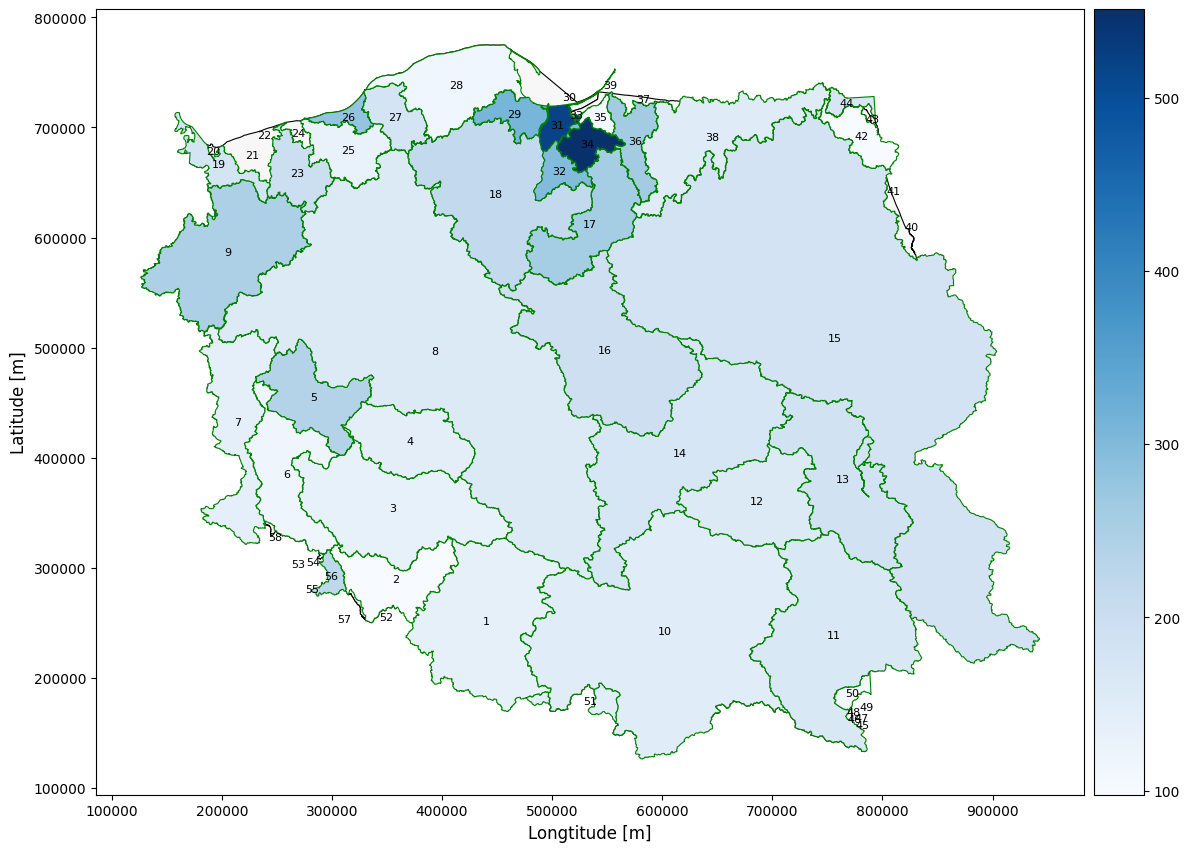

In [15]:
# Województwa
woj = get_map_wojewodztwa()

# Agregacja
agg_hydro = hydro.groupby("Zlewnia ID")[["Water Level", "Flow"]].agg(['mean', 'max', 'min','median'])
agg_hydro.columns = ['_'.join(col) for col in agg_hydro.columns]
agg_hydro.reset_index(inplace=True)

# Wykres
plot_zlewnia_stat(zlewnie, woj, agg_hydro, 'Water Level_mean', f'')


In [6]:
id = 6
wl_series2 = hydro[hydro["Zlewnia ID"] == id].groupby("Calendar Date")["Water Level"].mean()
wl_series2 = wl_series2.reset_index()

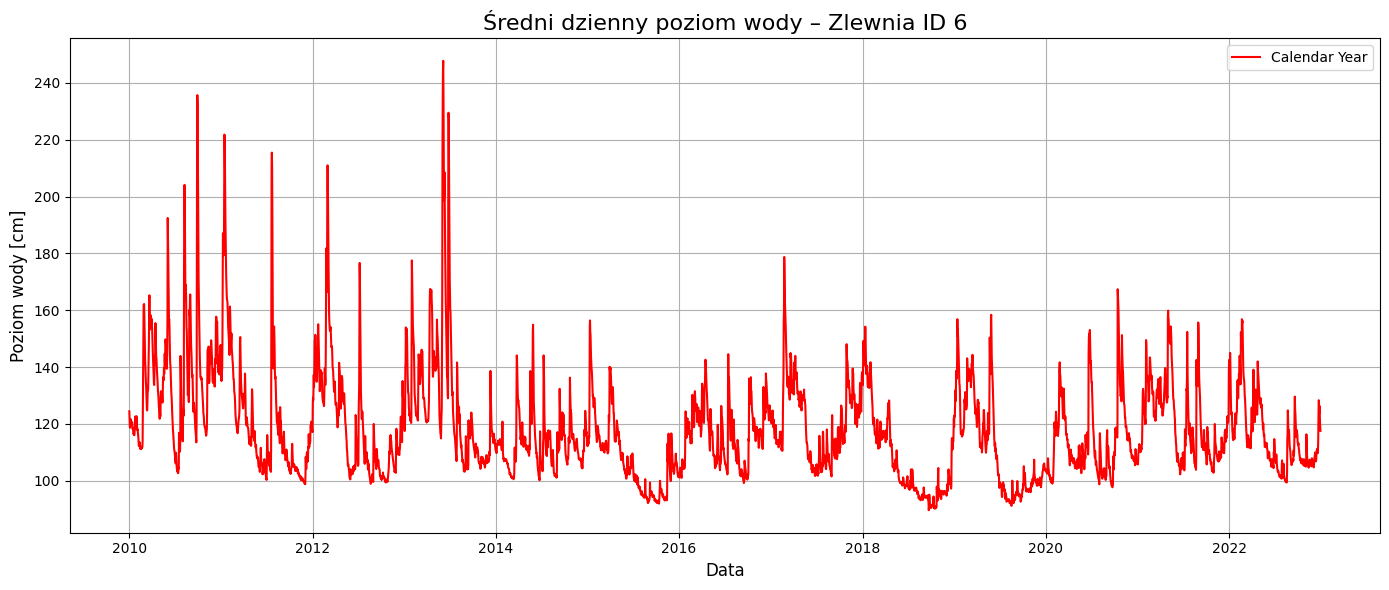

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(wl_series2["Calendar Date"],wl_series2["Water Level"],color='red',label="Calendar Year")
plt.title(f'Średni dzienny poziom wody – Zlewnia ID {id}', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Dołączenie stacji meteo do zlewni
gdf_m_zlewnia = gpd.sjoin(gdf_m, zlewnie, how='inner', predicate='within').drop(['naz_zlewni','id_hyd_10','id_hyd_50','guid'],axis=1)

In [9]:
map_meteo = gdf_m_zlewnia.set_index('Station Code')['Zlewnia ID']
meteo['Zlewnia ID'] = meteo['Station Code'].map(map_meteo)

In [10]:
opad_series = meteo[meteo["Zlewnia ID"] == id].groupby("Calendar Date")["Daily Precip Sum"].mean().reset_index()

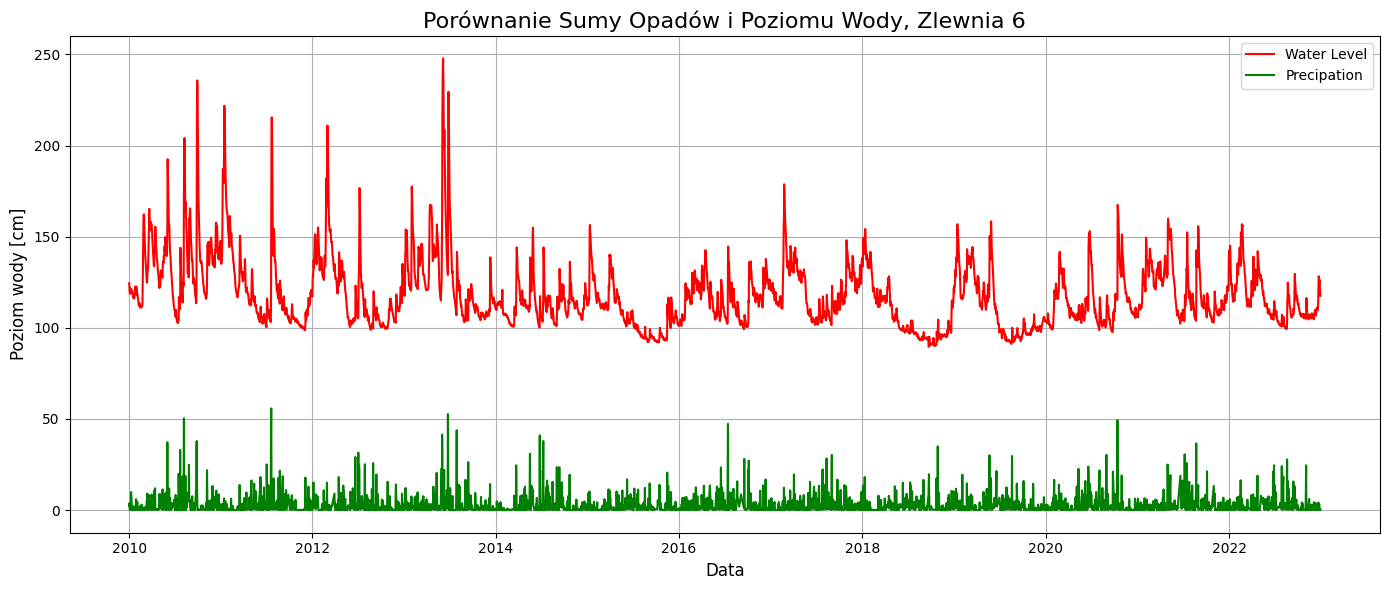

In [11]:
plt.figure(figsize=(14, 6))
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
wl_series2[['Normalized Water Level']] = scaler.fit_transform(wl_series2[['Water Level']])
opad_series[['Normalized Daily Precip Sum']] = scaler.fit_transform(opad_series[['Daily Precip Sum']])

plt.plot(wl_series2["Calendar Date"],wl_series2["Water Level"],color='red',label="Water Level")
plt.plot(opad_series["Calendar Date"],opad_series["Daily Precip Sum"],color='green',label="Precipation")
plt.title(f'Porównanie Sumy Opadów i Poziomu Wody, Zlewnia {id}', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

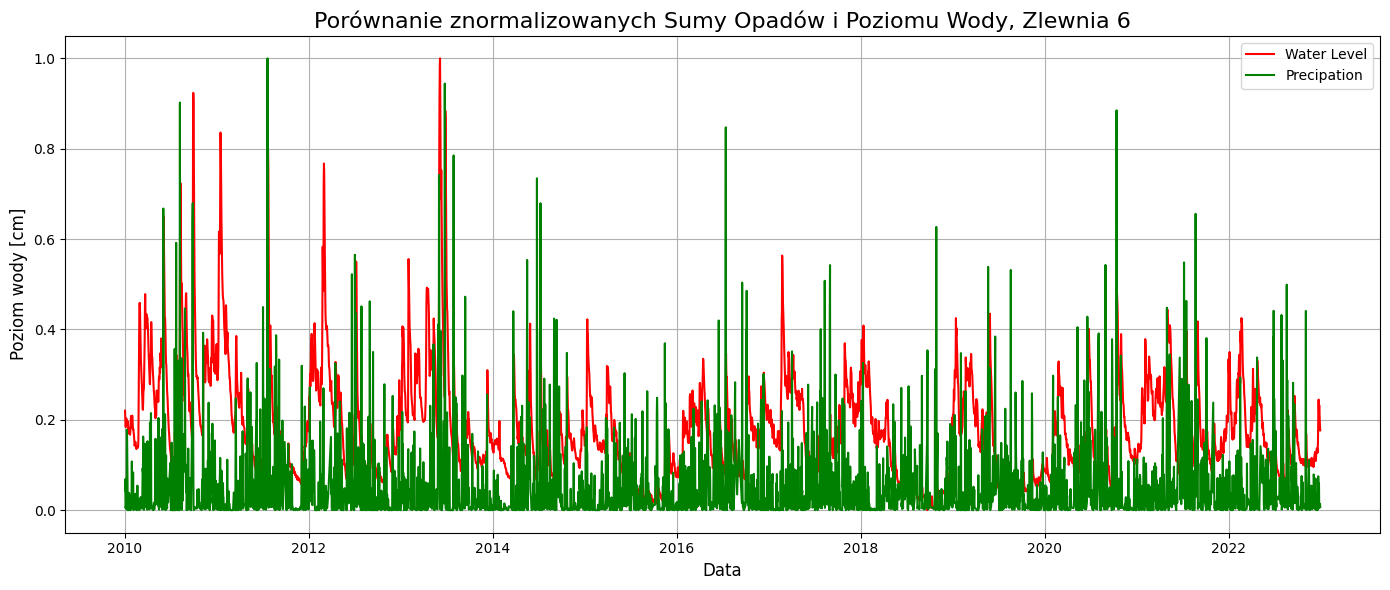

In [12]:
plt.figure(figsize=(14, 6))
plt.plot(wl_series2["Calendar Date"],wl_series2["Normalized Water Level"],color='red',label="Water Level")
plt.plot(opad_series["Calendar Date"],opad_series["Normalized Daily Precip Sum"],color='green',label="Precipation")
plt.title(f'Porównanie znormalizowanych Sumy Opadów i Poziomu Wody, Zlewnia {id}', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

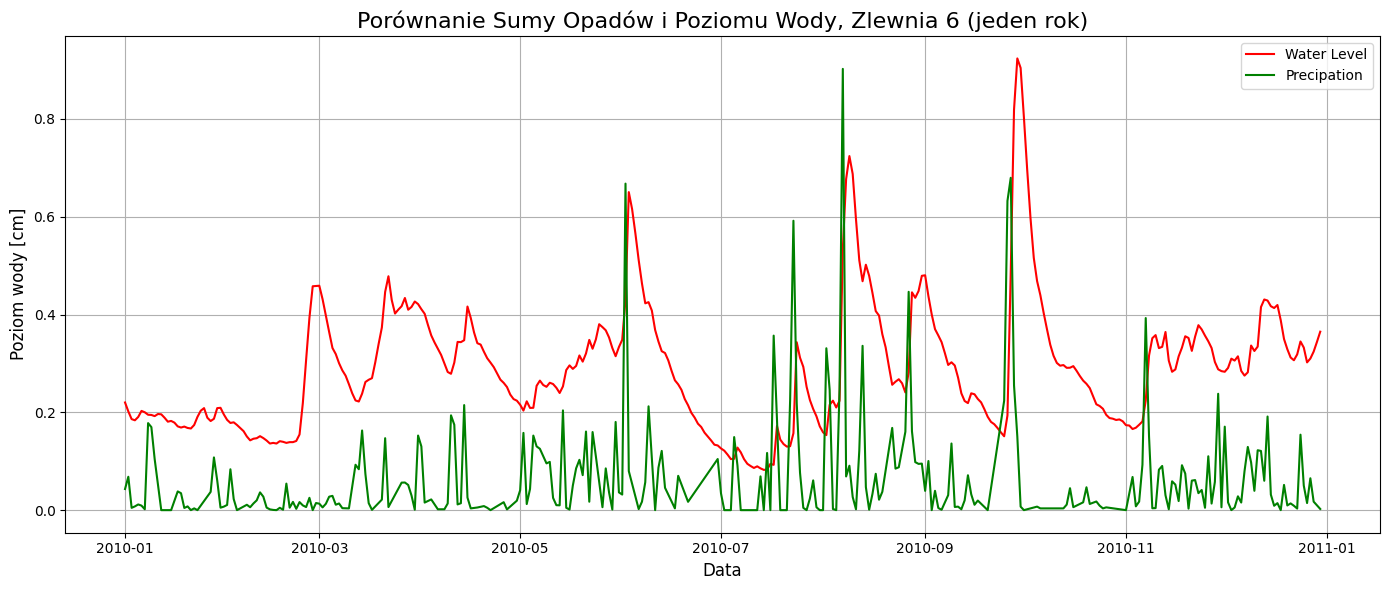

In [13]:
plt.figure(figsize=(14, 6))

wl_series2 = wl_series2[wl_series2['Calendar Date'] < '2010-12-31']
opad_series = opad_series[opad_series['Calendar Date'] < '2010-12-31']


plt.plot(wl_series2["Calendar Date"],wl_series2["Normalized Water Level"],color='red',label="Water Level")
plt.plot(opad_series["Calendar Date"],opad_series["Normalized Daily Precip Sum"],color='green',label="Precipation")
plt.title(f'Porównanie Sumy Opadów i Poziomu Wody, Zlewnia {id} (jeden rok)', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Analiza Lagu Hydroloicznego

💧 Najsilniejsza korelacja = 0.218 przy opóźnieniu 2 dni


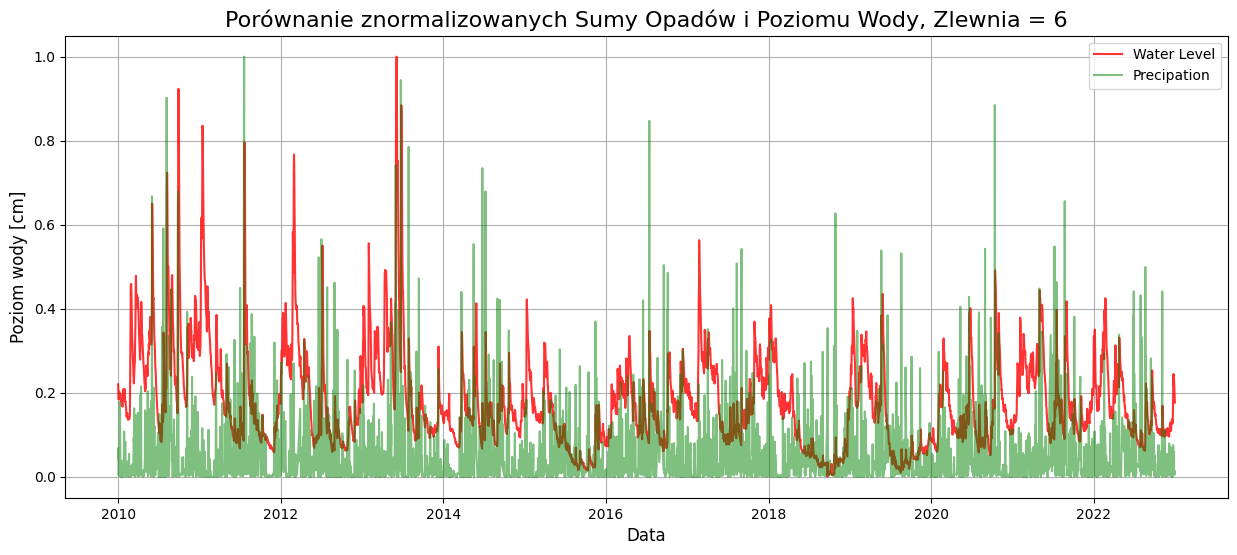

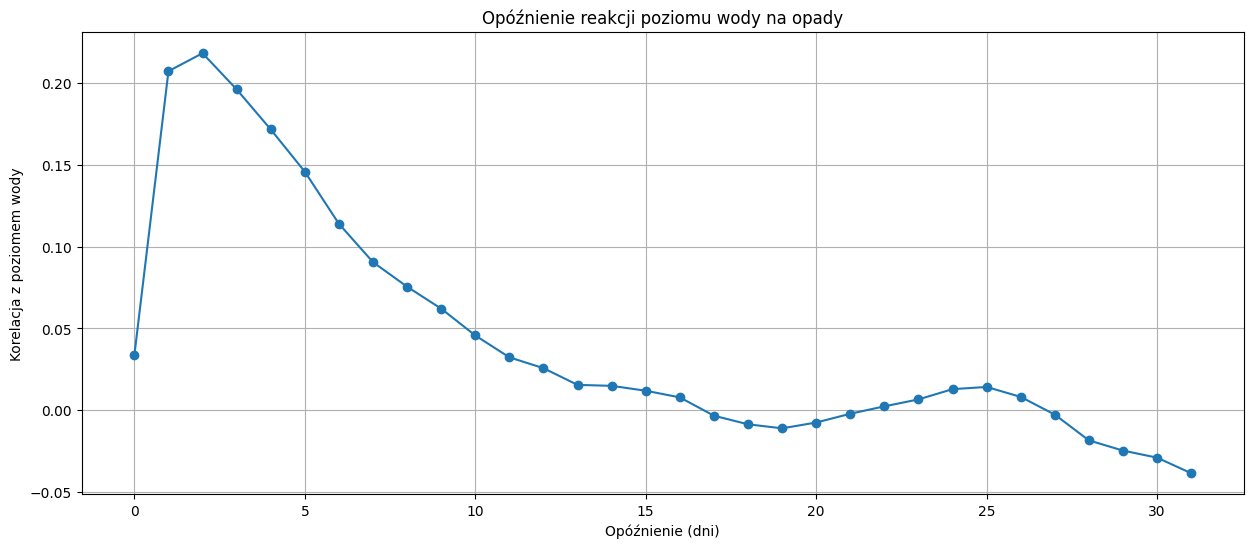

In [14]:
wl_series2 = hydro[hydro["Zlewnia ID"] == id].groupby("Calendar Date")["Water Level"].mean().reset_index()
opad_series = meteo[meteo["Zlewnia ID"] == id].groupby("Calendar Date")["Daily Precip Sum"].mean().reset_index()
scaler = MinMaxScaler()
wl_series2[['Normalized Water Level']] = scaler.fit_transform(wl_series2[['Water Level']])
opad_series[['Normalized Daily Precip Sum']] = scaler.fit_transform(opad_series[['Daily Precip Sum']])


# 1. Połącz dane na wspólnych datach (dla bezpieczeństwa)
merged = pd.merge(opad_series, wl_series2, on="Calendar Date", how="inner")

# 2. Ustal zakres opóźnień do sprawdzenia (np. do 20 dni)
max_lag = 31
correlations = []

# 3. Oblicz korelacje opóźnionych serii
for lag in range(0, max_lag + 1):
    shifted_precip = merged["Daily Precip Sum"].shift(lag)
    corr = shifted_precip.corr(merged["Water Level"])
    correlations.append((lag, corr))

# 4. Znajdź najlepszy lag
best_lag, best_corr = max(correlations, key=lambda x: abs(x[1]))

print(f"💧 Najsilniejsza korelacja = {best_corr:.3f} przy opóźnieniu {best_lag} dni")

plt.figure(figsize=(15, 6))
plt.plot(wl_series2["Calendar Date"],wl_series2["Normalized Water Level"],color='red',label="Water Level",alpha=0.8)
plt.plot(opad_series["Calendar Date"],opad_series["Normalized Daily Precip Sum"],color='green',label="Precipation",alpha=0.5)
plt.title(f'Porównanie znormalizowanych Sumy Opadów i Poziomu Wody, Zlewnia = {id}', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.grid(True)
plt.legend()

# 5. Wykres korelacji
plt.figure(figsize=(15, 6))
lags, corr_vals = zip(*correlations)
plt.plot(lags, corr_vals, marker='o')
plt.xlabel("Opóźnienie (dni)")
plt.ylabel("Korelacja z poziomem wody")
plt.title("Opóźnienie reakcji poziomu wody na opady")
plt.grid(True)
plt.show()

